# Automatic Counterfactual Fairness Process

## Imports

In [ ]:
import pandas as pd
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.utils.cit import chisq, fisherz, gsq, kci, mv_fisherz
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader
import torch 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#import causalGenTool
from fairness.Max.CGT.core.utils import show, handle_dcausation, graph2adj, check_cycles
from fairness.Max.CGT.core.generator import CausalGenerator, norm_col, KL
from fairness.Max.CGT.core.discovery import Discoverer
from fairness.Max.CGT.core.bias import Observer
from fairness.Max.CGT.core.assessment import Assessor
from fairness.Max.CGT.core.mwcf_train.trainer import Model
from fairness.Max.CGT.core.mwcf_train.utils import MWCF_loss, dataset
from fairness.Max.CGT.core.fitter import LinearSCM

## Creation of Synthetic Dataset

We start by generating a whole new synthetic dataset that we will consider as our Real World Data Distribution.
We give in input the adjency matrix with corresponding weights for every edges: $adj[i,j] =! 0$ corresponds to the edge $x_i \rightarrow x_j$

Current Node:  x0
Current Node:  x1
Current Node:  x2
Current Node:  x3
Current Node:  x5
Current Node:  x4
Current Node:  x6
Current Node:  x4
Current Node:  x5
Current Node:  x6
Current Node:  x7
Current Node:  x8
Current Node:  x0
Current Node:  x1
Current Node:  x2
Current Node:  x3
Current Node:  x4
Current Node:  x5
Current Node:  x6
Current Node:  x7
Current Node:  x8
Current Node:  x0
Current Node:  x1
Current Node:  x2
Current Node:  x3
Current Node:  x4
Current Node:  x5
Current Node:  x6
Current Node:  x7
Current Node:  x8


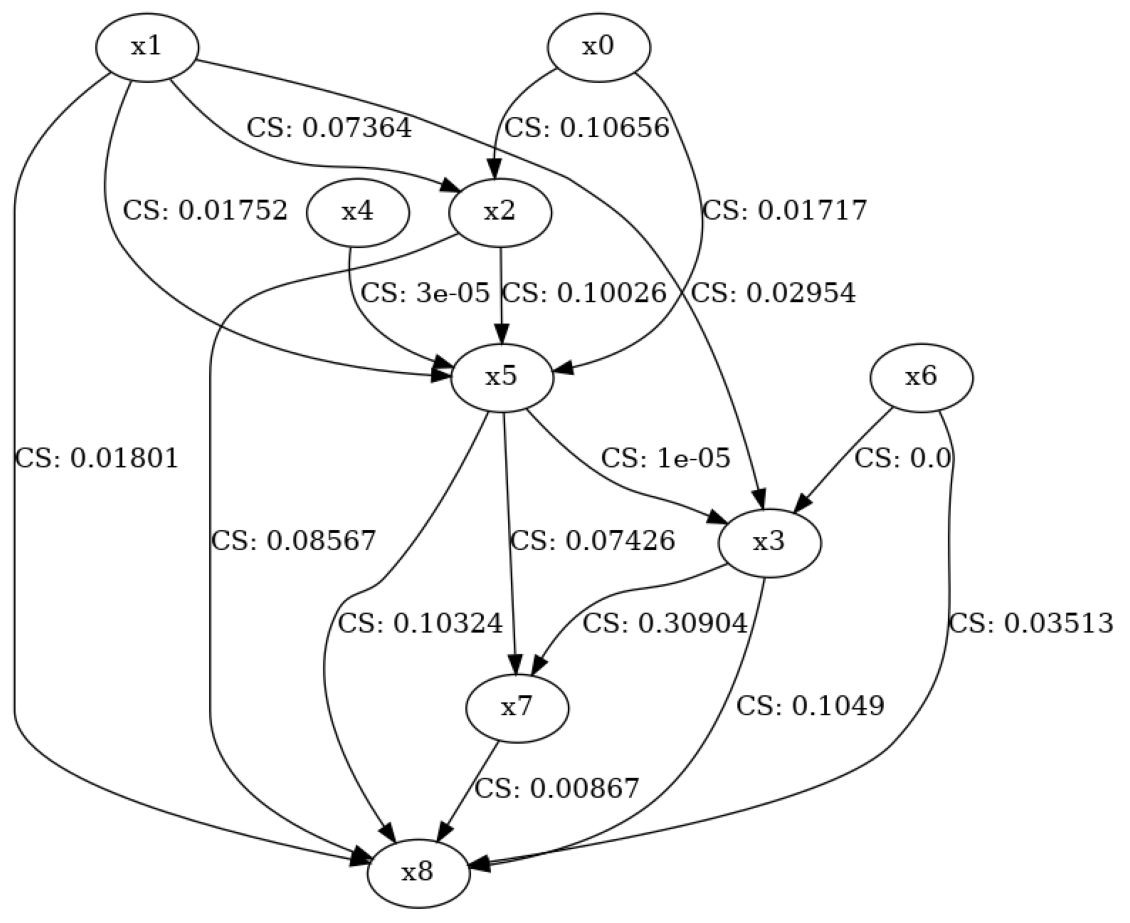

In [2]:
#Define adjency matrix
adj = np.array([[0, 0, -6, 0, 0, 1, 0, 0, 0], \
                [0, 0, -4, 1, 0, 1, 0, 0, -2], \
                [0, 0, 0, 0, 0, -5, 0, 0, 5],
                [0, 0, 0, 0, 0, 0, 0, 5, -5],
                [0, 0, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 0, 3, 0, 0, 0, -3, -4],
                [0, 0, 0, -7, 0, 0, 0, 0, 3],
                [0, 0, 0, 0, 0, 0, 0, 0, 1],
                [0, 0, 0, 0, 0, 0, 0, 0, 0]])

#Instantiate a CausalGenerator
test = CausalGenerator(adj, var_names=None, size=100000, normalize=False)
test.graph_from_adjacency_matrix(directed=True)
test.generate_data()
#Compute each Conditionnal Probability Distributions /!\ Mandatory to get the Causal Strength
test.compute_CPDs()
#Compute Causal Strength for every edges
test.allEdgesCausalStrength()
#Generate the counterfactual worlds with respect to a specified sensible parameter
test.generate_counterfactual_worlds('x0')
test.show_graph()

## Biasing step

We then simulate an observation process. Indeed, a dataset is an observation, biased or not, of the Real World Data Distribution. 

In [ ]:
#We use a dict to define which probability we want to ensure, here P(x8 = 1 |x0 = 1) = 0.7
probs = {
    'keys':['x0','x8'],
    'values': (1,1),
    'prob': 0.7
}

#We store the desired probabilities in a list
conds = [probs]

#Creation of an Observation process based on the real world data distribution 
#and of a sensible parameter
observer = Observer(test.data, 'x0')
#Generate an observation, biased with the above list
sample = observer.observe(bias=conds, n_data=10000, debug=False)

## Discovery step

After obtaining a dataset we can now put ourselves in a Datascientist point of view. Given a dataset how can one create a Counterfactually Fair model ? 
To use the Counterfactual Fairness notion we have to discover the graph. For each graph we then handle double causations as so:

For each double causation

    - Create two copies of the graph
    - In the first one turn the spurious edge into $\leftarrow$
    - In the second one turn the spurious edge into $\rightarrow$
    - Remove init graph

Then for each graph we infer a SCM that we will use to generate counterfactual values.

That's what is done in the following

In [3]:
#Parameter to perform a grid search.
#Here we will only perform a grid search with an algorithm and a combination of parameters.
alg ='pc'
pc_param = {'alpha' : [0.05], 'indep_test':[gsq]}
results = {}
discoverer = Discoverer()

#Perform a grid_search
discoverer.grid_search(sample.to_numpy(), alg, pc_param, test.graph)
true_graph = discoverer.grid_search_results()
#Get adjency of discovered graph
adj_  = graph2adj(discoverer.discovered_graphs[-1].graph)

#/!\ True adj 
#adj_ = (test.adjency_matrix != 0).astype(float)

#Handle double causations
adj_list = handle_dcausation(adj_)

#Remove adjency that contains cycles
adj_list = [adj for adj in adj_list if not check_cycles(adj, True)]

#Fit a scm on the corresponding adjency matrixes
scm_fitter = [LinearSCM(adj) for adj in adj_list]
scms = [fitter.fit(sample) for fitter in scm_fitter]

#Compute counterfactuals of each SCM
counterfactuals = []
for idx, scm in enumerate(scms):
    #Empty dataframe
    empty = pd.DataFrame(0, index=range(len(sample)), columns=sample.columns)
    #Instantiate a Causal Generator to generate data
    new_gen = CausalGenerator(adjency_matrix=scm, normalize=True)
    new_gen.graph_from_adjacency_matrix(directed=True)
    print("Init Data: ",str(idx))
    #Generate dumb data and replace it by dataset, store noises infered with the SCMs
    new_gen.generate_data(store=True)
    sample = sample.reset_index(drop=True)
    new_gen.noise = scm_fitter[idx].noises[:,sample.index]
    new_gen.data = sample
    
    print("CF Data: ",str(idx))
    #Generate Counterfactual Worlds
    new_gen.generate_counterfactual_worlds('x0')

    #Add Counterfactuals into the empty dataframe
    empty.update(new_gen.counterfactual_world_1.iloc[sample[sample['x0'] == 0].index])
    empty.update(new_gen.counterfactual_world_0.iloc[sample[sample['x0'] == 1].index])
    counterfactuals.append(empty)

0.7001015228426396
Current parameters used:  {'alpha': 0.05, 'indep_test': <function gsq at 0x7f2ae7710ca0>}


Depth=6, working on node 8: 100%|██████████| 9/9 [00:00<00:00, 235.49it/s] 
/home/maxence/anaconda3/envs/causal-learn-test/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maxence/anaconda3/envs/causal-learn-test/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maxence/anaconda3/envs/causal-learn-test/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maxence/anaconda3/envs/caus

Init Data:  0
Current Node:  x0
Current Node:  x1
Current Node:  x2
Current Node:  x5
Current Node:  x7
Current Node:  x3
Current Node:  x6
Current Node:  x8
Current Node:  x2
Current Node:  x3
Current Node:  x4
Current Node:  x5
Current Node:  x6
Current Node:  x7
Current Node:  x8
CF Data:  0
Current Node:  x0
Current Node:  x1
Current Node:  x2
Current Node:  x5
Current Node:  x8
Current Node:  x2
Current Node:  x3
Current Node:  x4
Current Node:  x5
Current Node:  x6
Current Node:  x7
Current Node:  x8
Current Node:  x0
Current Node:  x1
Current Node:  x2
Current Node:  x5
Current Node:  x8
Current Node:  x2
Current Node:  x3
Current Node:  x4
Current Node:  x5
Current Node:  x6
Current Node:  x7
Current Node:  x8


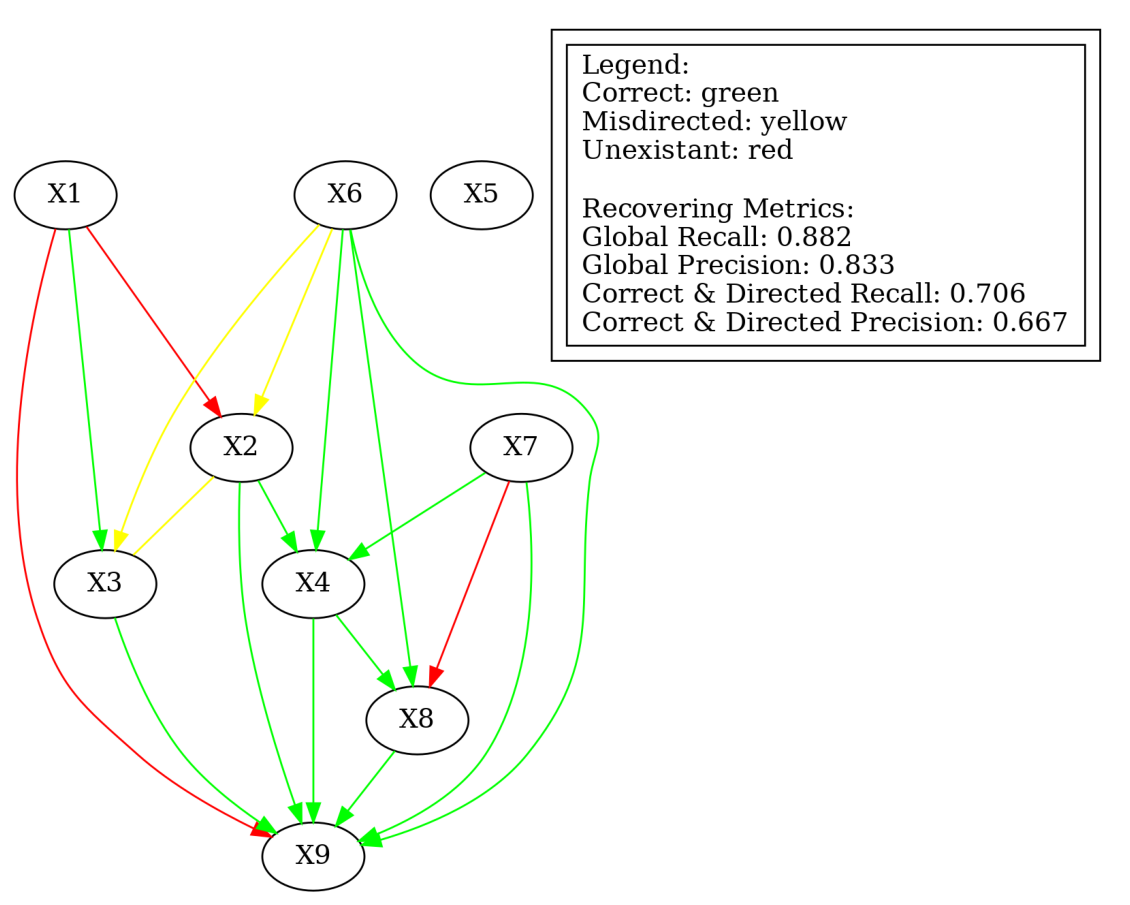

In [10]:
show(discoverer.discovered_graphs_pyd[0])

## Training Step

We are now ready to train our ML model.
We first start by creating the dataset and dataloader.
We then train our model several times increasing the lambda in the loss. We keep track of the precision and the counterfactuall accuracy of the model

In [4]:
#Train test split
X_train, X_test, y_train, y_test= train_test_split(sample.iloc[:,:-1], sample.iloc[:,-1], test_size=0.2)
counterfactuals_train = [counterfactual.iloc[X_train.index] for counterfactual in counterfactuals]
counterfactuals_test = [counterfactual.iloc[X_test.index] for counterfactual in counterfactuals]

#Datasets
trainset = dataset(X_train.values, y_train.values, counterfactuals_train)
testset = dataset(X_test.values, y_test.values, counterfactuals_test)

#DataLoader
trainloader = DataLoader(trainset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [5]:
#training loop for curve plotting
import torch

cf_accus = []
f1s = []
precisions = []
recalls = []
lambdas = np.arange(start=0,stop=10, step=0.2)
for lam in tqdm(lambdas):

    epochs = 200
    model = Model(8)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=5e-4)
    loss = MWCF_loss(lam=lam, eps=0.1)
    model.train()
    for i in range(epochs):
        trainloss_total = []
        valloss_total = []
        model.train(True)
        for j, (x_train, y_train, cf_train) in enumerate(trainloader):
            output = model(x_train)
            cf_output = torch.hstack([model(counter_data) for counter_data in cf_train])
            error = loss(output, y_train, cf_output)
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            trainloss_total.append(error)

        if (i % 100) == 0:
            model.train(False)
            for k, (x_test, y_test, cf_test) in enumerate(testloader):
                out_test = model(x_test)
                cf_out_test = torch.hstack([model(counter_data_test) for counter_data_test in cf_test])
                error = loss(out_test, y_test, cf_out_test)
                valloss_total.append(error)

    cf0 = torch.from_numpy(test.counterfactual_world_0.values[:,:-1]).float()
    cf1 = torch.from_numpy(test.counterfactual_world_1.values[:,:-1]).float()
    f1, precision, recall = model.evalmodified(testloader)
    cf_accu = model.eval_cf(cf0,cf1)

    cf_accus.append(cf_accu)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)



  0%|          | 0/50 [00:00<?, ?it/s]

F1 Score: tensor([0.9018]) -- Precision: tensor([0.8765]) -- Recall: tensor([0.9286])


  2%|▏         | 1/50 [00:34<28:27, 34.85s/it]

Counterfactuall Accuracy: tensor([0.7041])
F1 Score: tensor([0.7568]) -- Precision: tensor([0.8376]) -- Recall: tensor([0.6901])


  4%|▍         | 2/50 [01:08<27:14, 34.06s/it]

Counterfactuall Accuracy: tensor([0.9802])
F1 Score: tensor([0.7568]) -- Precision: tensor([0.8376]) -- Recall: tensor([0.6901])


  6%|▌         | 3/50 [01:42<26:37, 33.99s/it]

Counterfactuall Accuracy: tensor([0.9802])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


  8%|▊         | 4/50 [02:16<26:11, 34.15s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7568]) -- Precision: tensor([0.8376]) -- Recall: tensor([0.6901])


 10%|█         | 5/50 [02:50<25:35, 34.13s/it]

Counterfactuall Accuracy: tensor([0.9802])
F1 Score: tensor([0.7568]) -- Precision: tensor([0.8376]) -- Recall: tensor([0.6901])


 12%|█▏        | 6/50 [03:24<24:51, 33.89s/it]

Counterfactuall Accuracy: tensor([0.9802])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 14%|█▍        | 7/50 [03:59<24:34, 34.30s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 16%|█▌        | 8/50 [04:33<23:55, 34.18s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7568]) -- Precision: tensor([0.8376]) -- Recall: tensor([0.6901])


 18%|█▊        | 9/50 [05:07<23:25, 34.29s/it]

Counterfactuall Accuracy: tensor([0.9802])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 20%|██        | 10/50 [05:42<22:56, 34.41s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 22%|██▏       | 11/50 [06:16<22:12, 34.17s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 24%|██▍       | 12/50 [06:54<22:23, 35.37s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 26%|██▌       | 13/50 [07:28<21:40, 35.16s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 28%|██▊       | 14/50 [08:04<21:06, 35.17s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7568]) -- Precision: tensor([0.8376]) -- Recall: tensor([0.6901])


 30%|███       | 15/50 [08:37<20:13, 34.67s/it]

Counterfactuall Accuracy: tensor([0.9802])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 32%|███▏      | 16/50 [09:11<19:29, 34.39s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 34%|███▍      | 17/50 [09:46<19:04, 34.69s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 36%|███▌      | 18/50 [10:19<18:12, 34.15s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 38%|███▊      | 19/50 [10:53<17:37, 34.12s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 40%|████      | 20/50 [11:26<16:54, 33.81s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7574]) -- Precision: tensor([0.8378]) -- Recall: tensor([0.6911])


 42%|████▏     | 21/50 [12:00<16:19, 33.78s/it]

Counterfactuall Accuracy: tensor([0.9804])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 44%|████▍     | 22/50 [12:33<15:39, 33.55s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 46%|████▌     | 23/50 [13:07<15:07, 33.62s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 48%|████▊     | 24/50 [13:40<14:34, 33.65s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 50%|█████     | 25/50 [14:14<14:01, 33.66s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 52%|█████▏    | 26/50 [14:48<13:29, 33.74s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 54%|█████▍    | 27/50 [15:21<12:52, 33.60s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 56%|█████▌    | 28/50 [15:55<12:21, 33.71s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 58%|█████▊    | 29/50 [16:30<11:52, 33.95s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 60%|██████    | 30/50 [17:04<11:17, 33.88s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 62%|██████▏   | 31/50 [17:38<10:46, 34.03s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7568]) -- Precision: tensor([0.8376]) -- Recall: tensor([0.6901])


 64%|██████▍   | 32/50 [18:13<10:15, 34.20s/it]

Counterfactuall Accuracy: tensor([0.9802])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 66%|██████▌   | 33/50 [19:09<11:33, 40.82s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 68%|██████▊   | 34/50 [19:51<11:01, 41.32s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 70%|███████   | 35/50 [20:34<10:26, 41.78s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 72%|███████▏  | 36/50 [21:18<09:54, 42.45s/it]

Counterfactuall Accuracy: tensor([1.])
F1 Score: tensor([0.7443]) -- Precision: tensor([0.8340]) -- Recall: tensor([0.6720])


 74%|███████▍  | 37/50 [21:55<08:50, 40.80s/it]

Counterfactuall Accuracy: tensor([1.])


 74%|███████▍  | 37/50 [22:15<07:49, 36.10s/it]


KeyboardInterrupt: 

In [1]:
#Plot Precision and Counterfactual Accuracy
plt.plot(lambdas[:len(cf_accus)],[cf_accu.numpy() for cf_accu in cf_accus], label='Counterfactual Accuracy')
plt.plot(lambdas[:len(cf_accus)],[precision.numpy() for precision in precisions], label='Precision')
plt.title('Counterfactual Accuracy & Model Precision in function of lamba')
plt.xlabel('Lambda')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.show()

NameError: name 'plt' is not defined